In [1]:
'''
!git clone https://github.com/rajanlab/CURBD.git
import os 
os.chdir('/content/CURBD/')
'''

"\n!git clone https://github.com/rajanlab/CURBD.git\nimport os \nos.chdir('/content/CURBD/')\n"

In [59]:
import numpy as np
import numpy.random as npr
import pylab
import curbd
import math
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import torch.optim as optim
import pickle 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
print (device)

cpu


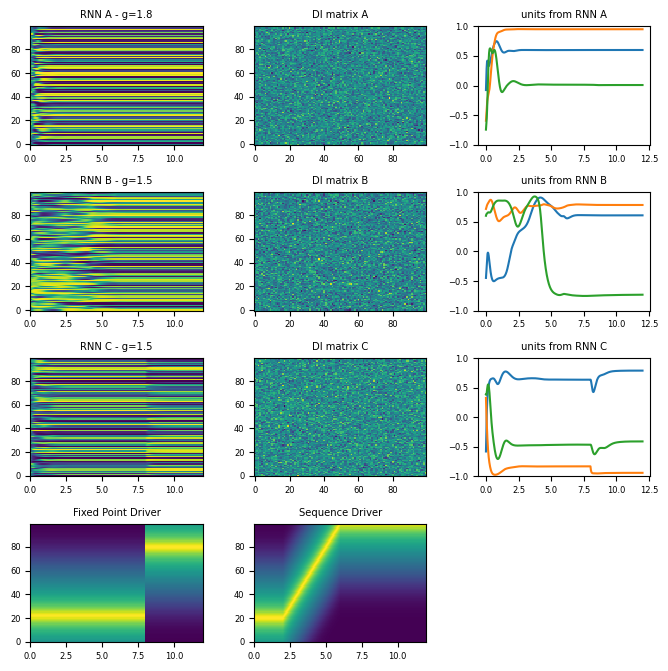

In [20]:
sim = curbd.threeRegionSim(number_units=100,
                           ga=1.8,
                           gb=1.5,
                           gc=1.5,
                           tau=0.1,
                           fracInterReg=0.05,
                           ampInterReg=0.02,
                           fracExternal=0.5,
                           ampInB=1,
                           ampInC=-1,
                           dtData=0.01,
                           T=10,
                           leadTime=2,
                           bumpStd=0.2,
                           )

In [61]:
with open("simulation.pkl", "wb") as f:
    pickle.dump(sim, f)

In [5]:
#three regions with each region having 100 units and 1201 time series data
activity = np.concatenate((sim['Ra'], sim['Rb'], sim['Rc']), 0) #300 x 1201
activity = activity[:,:300]

Na = sim['params']['Na']
Nb = sim['params']['Nb']
Nc = sim['params']['Nc']

regions = []
regions.append(['Region A', np.arange(0, Na)])
regions.append(['Region B', np.arange(Na, Na + Nb)])
regions.append(['Region C', np.arange(Na + Nb, Na + Nb + Nc)])
regions = np.array(regions, dtype=object)

# Initializing the parameters 

In [22]:
dtData=sim['params']['dtData'] # time step of training data
# dtData=None
dtFactor=5 # number of interpolation steps for RNN 
regions=regions # number of regions and names of the regions
# tauRNN=2*sim['params']['tau']/2 # decay constant of RNN 
tauRNN=50 # decay constant of RNN 

g=1.5 # instability constant 
tauWN=0.1 #decay constant on filtered white noise inputs
ampInWN=0.01 #input amplitude of filtered white noise 
resetPoints=None
plotStatus=True
regions=None


In [23]:
dtData

0.01

In [24]:
if dtData is None: #0.01
    print('dtData not specified. Defaulting to 1.');
    dtData = 1;
if resetPoints is None:
    resetPoints = [0, ]
if regions is None:
    regions = {}

In [25]:
number_units = activity.shape[0] #300 -- the total number of units 
number_learn = activity.shape[0] #300
dtRNN = dtData / float(dtFactor) # 0.01/5=0.002

In [26]:
dtFactor

5

In [27]:
learnList = npr.permutation(number_units) #randomize the units
iTarget = learnList[:number_learn]
iNonTarget = learnList[number_learn:] # []

tData = dtData*np.arange(activity.shape[1]) #   [0, 0.01, 0.02 ....,12.01] #1201 input time steps 
tRNN = np.arange(0, tData[-1] + dtRNN, dtRNN) # [0, 0.002, 0.004 ...., 12.01] #6000 rnn time steps

# External Input to RNN

In [28]:
ampWN = math.sqrt(tauWN/dtRNN) # (0.1/0.002)
iWN = ampWN * npr.randn(number_units, len(tRNN)) #gaussian noise ? #300x6001
inputWN = np.ones((number_units, len(tRNN))) #300x6001
# print("inputWN : ",inputWN)
for tt in range(1, len(tRNN)):
    inputWN[:, tt] = iWN[:, tt] + (inputWN[:, tt - 1] - iWN[:, tt])*np.exp(- (dtRNN / tauWN)) # solve the above differential equation 
inputWN = ampInWN * inputWN # external input h(t)


# Set up target training data

In [29]:
Adata = activity.copy()
Adata = Adata/Adata.max()
Adata = np.minimum(Adata, 0.999) # elementwise minimum 
Adata = np.maximum(Adata, -0.999) # elementwise max
print (Adata.shape)

(300, 300)


# Model Definition

In [116]:
import sys 

class CTRNN(nn.Module):
    """Continuous-time RNN."""
    def __init__(self,
                 g,
                 tauRNN,
                 dtRNN,
                 input_units,
                 output_units,
                 dt=None,
                 **kwargs):
      
        super(CTRNN,self).__init__()

        self.tauRNN = tauRNN
        self.dtRNN=dtRNN
        self.g=g
        self.input_units=input_units
        self.output_units=output_units
        self.J = nn.Parameter(self.g * torch.Tensor(npr.randn(input_units, output_units) / math.sqrt(output_units)))

    def forward(self, hidden, noise=None):
        if(noise is not None):
           noise = torch.zeros_like(noise)
        
        """Propogate input through the network."""
        
        # When calculating fixed points: We want to find _hidden_ vectors such that -hidden + JR equals the 0 vector.
        activation = torch.tanh(torch.Tensor(hidden))
        JR = torch.matmul(self.J, activation).reshape((self.input_units,1))
        

        new_hidden = hidden + self.dtRNN*(-hidden + JR)/self.tauRNN
        return activation, new_hidden



In [104]:
class pseudomodel(nn.Module):
    def __init__(self, hidden_size, input_units):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_units = input_units
        self.candidate_hidden = nn.Parameter(torch.rand(hidden_size))
        

    def forward(self, J_matrix):
        activation = torch.tanh(torch.Tensor(self.candidate_hidden))
        JR = torch.matmul(J_matrix, activation).reshape((self.input_units, 1))
        
        difference = -self.candidate_hidden + JR
        return difference

    

In [105]:
sm = pseudomodel(hidden_size=hidden.shape, input_units=rnn_model.input_units)

In [102]:
target = torch.zeros

torch.Size([300, 1])

In [122]:
sm.candidate_hidden.shape

torch.Size([300, 1])

In [120]:
rnn_model(sm.candidate_hidden)[0] - sm.candidate_hidden

tensor([[-1.4015e-05],
        [ 2.1213e-03],
        [ 6.0007e-05],
        [-1.3445e-05],
        [ 1.2293e-07],
        [-2.8163e-06],
        [-1.6950e-05],
        [ 2.6170e-07],
        [-1.0794e-06],
        [-3.0864e-04],
        [-7.5065e-06],
        [-2.6377e-04],
        [-4.2584e-05],
        [ 1.0753e-04],
        [-9.9055e-06],
        [ 3.8657e-04],
        [ 1.0477e-07],
        [ 8.5216e-07],
        [-3.0439e-05],
        [ 9.7398e-06],
        [-3.8177e-05],
        [ 3.8743e-07],
        [-3.6694e-07],
        [-3.7532e-07],
        [ 3.9581e-09],
        [ 2.4159e-06],
        [ 8.9500e-06],
        [ 2.6058e-06],
        [-3.8714e-03],
        [-5.9512e-05],
        [ 1.5507e-07],
        [-4.9174e-07],
        [ 2.3343e-05],
        [-4.5873e-05],
        [-7.3947e-07],
        [ 6.1262e-06],
        [ 6.4231e-05],
        [ 3.3472e-06],
        [-1.8347e-07],
        [-4.3306e-08],
        [-3.7160e-07],
        [ 6.3609e-06],
        [-1.7002e-04],
        [-8

In [113]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(sm.parameters(), lr=1e-4)

for i in range(10000):
    diffs = sm(JM)
    loss = loss_function(diffs, torch.zeros_like(diffs))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)
    

tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.00

In [117]:

rnn_model = CTRNN(g=g,
                  tauRNN=tauRNN,
                  dtRNN=dtRNN,
                  input_units=number_units,
                  output_units=number_units)

rnn_model.to(device)

weights_initial = rnn_model.J.detach().cpu().numpy().copy()


In [80]:
#torch.save(rnn_model.state_dict(), "CTRNN_weights_NoNoise.pt")

In [118]:
rnn_model.load_state_dict(torch.load("CTRNN_weights_NoNoise.pt"))

<All keys matched successfully>

In [83]:
first =  torch.tanh(torch.Tensor(Adata[:, 0, np.newaxis])).to(device)
rnn_model(first)

torch.Size([300, 1])
torch.Size([300, 1])


SystemExit: 

c:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Training

In [65]:
optimizer = optim.Adam(rnn_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
loss_list = []
# RNN = np.zeros((number_units, len(tRNN)))

for epoch in range(1000):
    tLearn = 0 
    iLearn = 0 
    loss = 0

    hidden = torch.tanh(torch.Tensor(Adata[:, 0, np.newaxis])).to(device)
    # RNN[:, 0, np.newaxis] = hidden.detach().cpu().numpy()
    # output = hidden
    for i in range(1,len(tRNN)):
        tLearn += dtRNN
        
        # RNN[:, i, np.newaxis] = output.detach().cpu().numpy()

        output, hidden = rnn_model(hidden,
                                  torch.Tensor(inputWN[:, i, np.newaxis]).to(device))
        

        if tLearn >= dtData:
          tLearn=0
          running_loss = criterion(output,
                                   torch.Tensor(Adata[:, iLearn ,np.newaxis]).to(device))
          iLearn = iLearn + 1 
          loss+=running_loss
    optimizer.zero_grad()   # zero the gradient buffers
    if (epoch)%1 ==0 :
      print (f"Epoch is {epoch}, loss is {loss}")
    loss.backward()
    optimizer.step()    # Does the update
    loss_list.append(loss)

Epoch is 0, loss is 6.3029913902282715
Epoch is 1, loss is 6.300104141235352
Epoch is 2, loss is 6.297233581542969
Epoch is 3, loss is 6.294361591339111
Epoch is 4, loss is 6.291511058807373
Epoch is 5, loss is 6.288665294647217
Epoch is 6, loss is 6.285822868347168
Epoch is 7, loss is 6.282979965209961
Epoch is 8, loss is 6.280144691467285
Epoch is 9, loss is 6.277306079864502
Epoch is 10, loss is 6.274468898773193
Epoch is 11, loss is 6.271630764007568
Epoch is 12, loss is 6.268797874450684
Epoch is 13, loss is 6.265968322753906
Epoch is 14, loss is 6.263136386871338
Epoch is 15, loss is 6.260305404663086
Epoch is 16, loss is 6.257480621337891
Epoch is 17, loss is 6.254653453826904
Epoch is 18, loss is 6.2518310546875
Epoch is 19, loss is 6.2490057945251465
Epoch is 20, loss is 6.24618673324585
Epoch is 21, loss is 6.243370056152344
Epoch is 22, loss is 6.240555763244629
Epoch is 23, loss is 6.237740516662598
Epoch is 24, loss is 6.234931468963623
Epoch is 25, loss is 6.2321209907531

KeyboardInterrupt: 

In [33]:
tRNN.shape

(1496,)

In [14]:
dtData

0.01

In [15]:
dtRNN

0.01

# Save Weights

In [69]:
state = {
        'epoch': epoch,
        'state_dict': rnn_model.state_dict(),
        'optimizer': optimizer.state_dict(),
}

savepath='checkpoint.t7'

torch.save(state,savepath)


In [ ]:
del rnn_model

rnn_model = CTRNN(g=g,
                  tauRNN=tauWN,
                  dtRNN=dtRNN,
                  input_units=number_units,
                  output_units=number_units).to(device)


# Validation

In [66]:
checkpoint = torch.load("CTRNN_weights1.pt")
rnn_model.load_state_dict(checkpoint)
#optimizer.load_state_dict(checkpoint['optimizer'])
#epoch = checkpoint['epoch']


def validate(model,tRNN):
    
    with torch.no_grad():
      hidden = torch.tanh(torch.Tensor(Adata[:, 0, np.newaxis])).to(device)
      tLearn = 0 
      iLearn = 0 
      predicted=[]
      gt=[]

      for i in range(1,len(tRNN)):
          tLearn += dtRNN
          
          output, hidden = rnn_model(hidden,
                                     torch.Tensor(inputWN[:, i, np.newaxis]).to(device))
          

          if tLearn >= dtData:
            tLearn=0
            predicted.append(torch.tensor(output).detach().cpu().numpy())
            gt.append(torch.Tensor(Adata[:, iLearn ,np.newaxis]).to(device).detach().cpu().numpy())
            iLearn = iLearn + 1 
            
                
    return predicted, gt

preds,actual = validate(rnn_model,tRNN=tRNN)

C:\Users\Andrew\AppData\Local\Temp\ipykernel_5864\2400005635.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted.append(torch.tensor(output).detach().cpu().numpy())


# Plot the activity of a neuron 

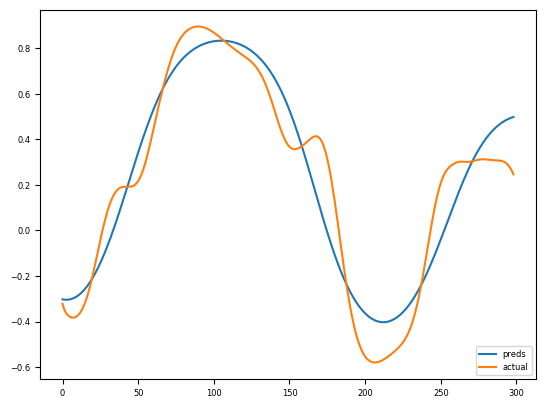

In [67]:
neuron_id = 1
x = list(range(len(preds)))
p=[pred[neuron_id][0] for pred in preds]
a=[act[neuron_id][0] for act in actual]


plt.plot(p)
plt.plot(a)
plt.legend(["preds", "actual"], loc ="lower right")
plt.show()

# Plot the average activity of regions

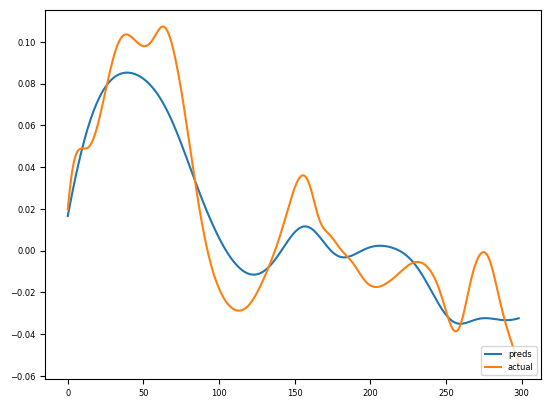

In [68]:
p_area=[pred[:100].mean() for pred in preds]
a_area=[act[:100].mean() for act in actual]


plt.plot(p_area)
plt.plot(a_area)
plt.legend(["preds", "actual"], loc ="lower right")
plt.show()

In [ ]:
# fig, ax =plt.subplots(1,2)

# sns.heatmap(weights_initial[0:10,0:10], ax=ax[0])
# sns.heatmap(rnn_model.J.detach().cpu().numpy()[0:10,0:10], ax=ax[1])

# plt.show()

In [ ]:
# sim={'RNN':,
#      J:, 
#      regions:,
#      params:}

# Compute CURBD

In [ ]:
# def computeCURBD(sim):
#     """
#     function [CURBD,CURBDLabels] = computeCURBD(varargin)
#     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     %
#     % Performs Current-Based Decomposition (CURBD) of multi-region data. Ref:
#     %
#     % Perich MG et al. Inferring brain-wide interactions using data-constrained
#     % recurrent neural network models. bioRxiv. DOI:
#     %
#     % Two input options:
#     %   1) out = computeCURBD(model, params)
#     %       Pass in the output struct of trainMultiRegionRNN and it will do the
#     %       current decomposition. Note that regions has to be defined.
#     %
#     %   2) out = computeCURBD(RNN, J, regions, params)
#     %       Only needs the RNN activity, region info, and J matrix
#     %
#     %   Only parameter right now is current_type, to isolate excitatory or
#     %   inhibitory currents.
#     %
#     % OUTPUTS:
#     %   CURBD: M x M cell array containing the decomposition for M regions.
#     %       Target regions are in rows and source regions are in columns.
#     %   CURBDLabels: M x M cell array with string labels for each current
#     %
#     %
#     % Written by Matthew G. Perich. Updated December 2020.
#     %
#     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     """
#     current_type = 'all'  # 'excitatory', 'inhibitory', or 'all'
#     RNN = sim['RNN']
#     J = sim['J'].copy()
#     regions = sim['regions']

#     if regions is None:
#         raise ValueError("regions not specified")

#     if current_type == 'excitatory':  # take only positive J weights
#         J[J < 0] = 0
#     elif current_type == 'inhibitory':  # take only negative J weights
#         J[J > 0] = 0
#     elif current_type == 'all':
#         pass
#     else:
#         raise ValueError("Unknown current type: {}".format(current_type))

#     nRegions = regions.shape[0]

#     # loop along all bidirectional pairs of regions
#     CURBD = np.empty((nRegions, nRegions), dtype=np.object)
#     CURBDLabels = np.empty((nRegions, nRegions), dtype=np.object)

#     for idx_trg in range(nRegions):
#         in_trg = regions[idx_trg, 1]
#         lab_trg = regions[idx_trg, 0]
#         for idx_src in range(nRegions):
#             in_src = regions[idx_src, 1]
#             lab_src = regions[idx_src, 0]
#             sub_J = J[in_trg, :][:, in_src]
#             CURBD[idx_trg, idx_src] = sub_J.dot(RNN[in_src, :])
#             CURBDLabels[idx_trg, idx_src] = "{} to {}".format(lab_src,
#                                                               lab_trg)
#     return (CURBD, CURBDLabels)

In [ ]:
"""class for fixed point analysis"""

import torch
import torch.nn.functional as F
from torch.autograd import Variable


class FixedPoint(object):
    def __init__(self, model, device, gamma=0.01, speed_tor=1e-06, max_epochs=200000,
                 lr_decay_epoch=10000):
        self.model = model
        self.device = device
        self.gamma = gamma
        self.speed_tor = speed_tor
        self.max_epochs = max_epochs
        self.lr_decay_epoch = lr_decay_epoch

        self.model.eval()

    def calc_speed(self, hidden_activated, const_signal):
        input_signal = const_signal.permute(1, 0, 2)
        pre_activates = self.model.w_hh(hidden_activated)
        activated = torch.tanh(pre_activates)

        speed = torch.norm(activated - hidden_activated)

        return speed

    def find_fixed_point(self, init_hidden, const_signal, view=False):
        new_hidden = init_hidden.clone()
        gamma = self.gamma
        result_ok = True
        i = 0
        while True:
            hidden_activated = Variable(new_hidden).to(self.device)
            hidden_activated.requires_grad = True
            speed = self.calc_speed(hidden_activated, const_signal)
            if view and i % 1000 == 0:
                print(f'epoch: {i}, speed={speed.item()}')
            if speed.item() < self.speed_tor:
                print(f'epoch: {i}, speed={speed.item()}')
                break
            speed.backward()
            if i % self.lr_decay_epoch == 0 and i > 0:
                gamma *= 0.5
            if i == self.max_epochs:
                print(f'forcibly finished. speed={speed.item()}')
                result_ok = False
                break
            i += 1

            new_hidden = hidden_activated - gamma * hidden_activated.grad

        fixed_point = new_hidden[0, 0]
        return fixed_point, result_ok

    def calc_jacobian(self, fixed_point, const_signal_tensor):
        fixed_point = torch.unsqueeze(fixed_point, dim=1)
        fixed_point = Variable(fixed_point).to(self.device)
        fixed_point.requires_grad = True
        input_signal = const_signal_tensor.permute(1, 0, 2)
        w_hh = self.model.w_hh.weight
        w_hh.requires_grad = False
        w_hh = w_hh.to(self.device)
        pre_activates = torch.unsqueeze(self.model.w_in(input_signal[0])[0], dim=1) + \
                        w_hh @ fixed_point + torch.unsqueeze(self.model.w_hh.bias, dim=1)

        if self.model.activation == 'relu':
            activated = F.relu(pre_activates)
        else:
            activated = torch.tanh(pre_activates)

        jacobian = torch.zeros(self.model.n_hid, self.model.n_hid)
        for i in range(self.model.n_hid):
            output = torch.zeros(self.model.n_hid, 1).to(self.device)
            output[i] = 1.
            jacobian[:, i:i + 1] = torch.autograd.grad(activated, fixed_point, grad_outputs=output, retain_graph=True)[
                0]

        jacobian = jacobian.numpy().T

        return jacobian

In [ ]:
import matplotlib
import numpy as np
import torch

matplotlib.use('Agg')

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# os.makedirs('figures', exist_ok=True)

freq_range = 51
time_length = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CTRNN(g=g,
              tauRNN=tauWN,
              dtRNN=dtRNN,
              input_units=number_units,
              output_units=number_units).to(device)

checkpoint = torch.load('checkpoint.t7')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']


analyzer = FixedPoint(model=model, device=device, max_epochs=1)

# hidden_list_list = np.zeros([30 * time_length, model.n_hid])
# fixed_point_list = np.zeros([15, model.n_hid])
# i = 0
    # while i < 15:
    #     freq = np.random.randint(10, freq_range + 1)
    #     const_signal = np.repeat(freq / freq_range + 0.25, time_length)
    #     const_signal = np.expand_dims(const_signal, axis=1)
    #     const_signal_tensor = torch.from_numpy(np.array([const_signal]))

    #     hidden = torch.zeros(1, 200)
    #     hidden = hidden.to(device)
    #     const_signal_tensor = const_signal_tensor.float().to(device)
    #     with torch.no_grad():
    #         hidden_list, _, _ = model(const_signal_tensor, hidden)

    #     fixed_point, result_ok = analyzer.find_fixed_point(torch.unsqueeze(hidden_list[:, 20, :], dim=0).to(device),
    #                                                        const_signal_tensor)
    #     if not result_ok:
    #         continue

    #     hidden_list_list[i * time_length:(i + 1) * time_length, ...] = hidden_list.cpu().numpy()[:, ...]
    #     fixed_point_list[i] = fixed_point.detach().cpu().numpy()
    #     i += 1







#     pca = PCA(n_components=3)
#     pca.fit(hidden_list_list)

#     fig = plt.figure()
#     ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=45, azim=134)

#     ax.set_xlabel('PC1')
#     ax.set_ylabel('PC2')
#     ax.set_zlabel('PC3')

#     print(hidden_list_list.shape)
#     print(fixed_point_list.shape)
#     pc_trajectory = pca.transform(hidden_list_list)
#     pc_fixed_point = pca.transform(fixed_point_list)

#     for i in range(15):
#         ax.plot(pc_trajectory.T[0, i * time_length:(i + 1) * time_length],
#                 pc_trajectory.T[1, i * time_length:(i + 1) * time_length],
#                 pc_trajectory.T[2, i * time_length:(i + 1) * time_length], color='royalblue')
#     ax.scatter(pc_fixed_point.T[0], pc_fixed_point.T[1], pc_fixed_point.T[2], color='red', marker='x')
#     plt.title('trajectory')
#     plt.savefig(f'figures/trajectory_{activation}.png', dpi=100)


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description='PyTorch RNN training')
#     parser.add_argument('--activation', type=str, default='tanh')
#     args = parser.parse_args()
#     # print(args)
#     main(args.activation)

<generator object Module.parameters at 0x7f9007e24270>

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1895,  0.5495,  0.2659,  ..., -0.4860,  0.5779,  0.4980],
         [-0.4533,  0.4590,  0.5454,  ..., -0.3497,  0.5164,  0.3412],
         [ 0.6986, -0.7471,  0.1420,  ...,  1.0444, -0.7326,  0.5419],
         ...,
         [ 0.9434, -0.0881, -0.8199,  ...,  0.7788, -0.7410,  0.8887],
         [-0.7179, -0.6997,  1.0262,  ...,  0.3180, -0.2262, -0.0932],
         [ 0.3452,  0.4718,  0.0323,  ..., -0.3254,  0.4039,  0.5861]],
        requires_grad=True)]